### dropbox

In [1]:
# import dropbox
# from dropbox import DropboxOAuth2FlowNoRedirect

# APP_KEY = "qi3onmgezlr00yv"
# auth_flow = DropboxOAuth2FlowNoRedirect(APP_KEY, use_pkce=True, token_access_type='offline')

# authorize_url = auth_flow.start()
# print("1. Go to: " + authorize_url)
# print("2. Click \"Allow\" (you might have to log in first).")
# print("3. Copy the authorization code.")
# auth_code = input("Enter the authorization code here: ").strip()

# try:
#     oauth_result = auth_flow.finish(auth_code)
# except Exception as e:
#     print('Error: %s' % (e,))
#     exit(1)

# with dropbox.Dropbox(oauth2_refresh_token=oauth_result.refresh_token, app_key=APP_KEY) as dbx:
#     dbx.users_get_current_account()
#     print("Successfully set up client!")

In [3]:
# print(oauth_result.refresh_token)

b_N3-an_VvQAAAAAAAAAAc7kTAMBxeYC9GlsLpwgFrXX3kbZr2li3f3GfGx-iGnr


##

In [29]:
import dropbox
import os
from io import BytesIO
import time
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import h5py

APP_KEY = 'qi3onmgezlr00yv'
REFRESH_TOKEN = 'b_N3-an_VvQAAAAAAAAAAc7kTAMBxeYC9GlsLpwgFrXX3kbZr2li3f3GfGx-iGnr'

In [30]:
def rss_coil_combine(image):
    squared_abs = np.abs(image)**2
    sum_of_squares = np.sum(squared_abs, axis=1)
    combined_images = np.sqrt(sum_of_squares)
    return combined_images

def normal_in_i(image):
    mean = np.mean(image)
    std = np.std(image)
    tmp = (image - mean) / (std + 1e-10)
    return tmp

def extract_subject_id(filename):
    numbers = re.findall(r'\d+', filename)
    if numbers:
        return int(numbers[-1])
    return None

def ifft2c(k):
    x = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(k, (-2,-1)), norm='ortho'), (-2,-1))
    return x

def fft2c(img):
    k = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img, (-2,-1)), norm='ortho'), (-2,-1))
    return k

In [31]:
def combine_dict(clear_dict, motion_dict):
    combined_dict = {}

    for key in clear_dict.keys() | motion_dict.keys(): 
        combined_dict[key] = {
            "clear_volume": clear_dict.get(key),
            "motion_volume": motion_dict.get(key)
        }
    return combine_dict

In [93]:
def crop(img, crop_size=320):
    height, width = img.shape[-2:]
    w_from = max(0, (width - crop_size) // 2)
    w_to = min(width, w_from + crop_size)
    h_from = (height - crop_size) // 2
    h_to = h_from + crop_size

    return img[:, h_from:h_to, w_from:w_to]

def padding(volume, size=320):
    slices, height, width = volume.shape
    pad_width = max(0, size - width) // 2 

    padded_volume = np.pad(
        volume,
        pad_width=((0, 0), (0, 0), (pad_width, pad_width)), 
        mode='edge'
    )
    return padded_volume

In [94]:
def dropbox_connect():
    dbx = dropbox.Dropbox(oauth2_refresh_token=REFRESH_TOKEN, app_key=APP_KEY)
    return dbx

def download_npy_file(dbx, dropbox_path, max_retries=3, delay=5):
    for attempt in range(max_retries):
        try:
            print(f"Downloading {dropbox_path}, attempt {attempt + 1}")
            _, response = dbx.files_download(dropbox_path)
            file_data = response.content
            npy_data = np.load(BytesIO(file_data))
            return npy_data
        except Exception as e:
            print(f"Error downloading {dropbox_path}: {e}")
            if attempt + 1 == max_retries:
                print(f"Max retries reached for {dropbox_path}")
                return None
            else:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)


def load_npy_from_dropbox(dbx, folder_path, max_workers=12):
    data_dict = {}

    try:
        folder_metadata = dbx.files_list_folder(folder_path)
        futures = {}

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            for entry in folder_metadata.entries:
                if isinstance(entry, dropbox.files.FileMetadata) and entry.name.endswith('.npy'):
                    file_path = os.path.join(folder_path, entry.name)
                    subject_id = extract_subject_id(entry.name)
                    future = executor.submit(download_npy_file, dbx, file_path)
                    futures[future] = subject_id
                    
            for future in as_completed(futures):
                subject_id = futures[future]
                volume = future.result()
                if volume is not None:
                    volume = rss_coil_combine(volume)
                    volume = crop(padding(volume,396),396)
                    for i in range(volume.shape[0]):
                        volume[i, :, :] = normal_in_i(volume[i, :, :])
                    
                    data_dict[subject_id] = volume[:8]

    except Exception as e:
        print(f"Error accessing folder {folder_path}: {e}")

    return data_dict

def load_file_from_dropbox(file_path):
    dbx = dropbox_connect()
    try:
        metadata, res = dbx.files_download(file_path)
        file_stream = BytesIO(res.content)
        np_array = np.load(file_stream)
        
        return np_array

    except dropbox.exceptions.ApiError as err:
        print(f'Error: {err}')
        return None

In [95]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Motion_data_whole_notrans_flair_0922'
    flair_motion = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(flair_motion)} npy files.")

Loaded 163 npy files.


In [89]:
def download_h5_file(dbx, dropbox_path, max_retries=3, delay=5):
    for attempt in range(max_retries):
        try:
            print(f"Downloading {dropbox_path}, attempt {attempt + 1}")
            _, response = dbx.files_download(dropbox_path)
            file_data = response.content
            
            h5_data =h5py.File(BytesIO(file_data))

            return h5_data

        except Exception as e:
            print(f"Error downloading {dropbox_path}: {e}")
            if attempt + 1 == max_retries:
                print(f"Max retries reached for {dropbox_path}")
                return None
            else:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)

def load_h5_from_dropbox(dbx, folder_path, max_workers=12):
    data = []
    try:
        folder_metadata = dbx.files_list_folder(folder_path)
        futures = []

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            for entry in folder_metadata.entries:
                if isinstance(entry, dropbox.files.FileMetadata) and entry.name.endswith('.h5'):
                    file_path = os.path.join(folder_path, entry.name)
                    subject_id = extract_subject_id(entry.name)
                    futures.append(executor.submit(download_h5_file, dbx, file_path))

            for future in as_completed(futures):
                h5 = future.result()
                data.append(h5)

    except Exception as e:
        print(f"Error accessing folder {folder_path}: {e}")

    return data

In [71]:
hf = download_h5_file(dbx, '/fastMRI_data_h5_flair/file_brain_AXFLAIR_201_6003018.h5')
print(list(hf.keys()))
print(list(hf.attrs))

['ismrmrd_header', 'kspace', 'reconstruction_rss']
['acquisition', 'max', 'norm', 'patient_id']


In [68]:
volume_kspace = hf['kspace'][()]
volume_img = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(volume_kspace), norm='ortho'))
print(volume_img.shape)

(16, 16, 640, 320)


(<matplotlib.image.AxesImage at 0x7efb40e51780>,
 (np.float64(-0.5), np.float64(319.5), np.float64(-0.5), np.float64(319.5)))

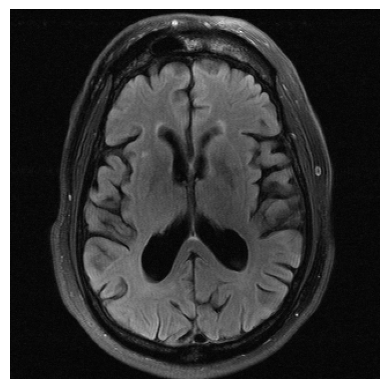

In [69]:
plt.imshow(hf['reconstruction_rss'][()][0], cmap='gray', origin='lower'), plt.axis('off')

In [90]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/fastMRI_data_h5_flair'
    flair_clear = load_h5_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(flair_clear)} npy files.")

Loaded 163 npy files.


In [ ]:
output_folder = "/root/motioncorrection/flair"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

n = 0
for hf in flair_clear:
    print(type(hf))
    volume = hf['reconstruction_rss'][()]
    n += 1
    
    num_slices = volume.shape[0]
    plt.figure(figsize=(20, 10))
    
    num_cols = min(8, num_slices)  
    num_rows = (num_slices + num_cols - 1) // num_cols  

    for i in range(num_slices):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(volume[i], cmap='gray', origin='lower')
        plt.axis('off')

    plt.tight_layout()
    output_path = os.path.join(output_folder, f"img_{n:03d}.png")  
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

In [15]:
# /Motion_data_whole_notrans_flair_0922/brain_AXFLAIR_200_6002541_motion.npy
# flair[3]

# volume = load_file_from_dropbox('/Motion_data_whole_notrans_flair_0922/brain_AXFLAIR_200_6002541_motion.npy')

In [96]:
def plot_volume(mr_data, output_folder):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    n = 0
    for volume in mr_data:
        n += 1
        print(volume.shape)
        
        num_slices = volume.shape[0]
        plt.figure(figsize=(20, 10))
        
        num_cols = min(8, num_slices)  
        num_rows = (num_slices + num_cols - 1) // num_cols  

        for i in range(num_slices):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(volume[i], cmap='gray', origin='lower')
            plt.axis('off')

        plt.tight_layout()
        output_path = os.path.join(output_folder, f"img_{n:03d}.png")  
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()

In [97]:
output_folder = "/root/motioncorrection/flair/motion"
plot_volume(flair_motion.values(), output_folder)

(8, 396, 395)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 395)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 395)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 396, 396)
(8, 39

In [6]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Motion_data_whole_notrans_t2_0922'
    t2_motion = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(t2_motion)} npy files.")

Error downloading /Motion_data_whole_notrans_t2_0922/brain_AXT2_207_2070613_motion.npy: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying in 5 seconds...
Error downloading /Motion_data_whole_notrans_t2_0922/brain_AXT2_205_2050141_motion.npy: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying in 5 seconds...
Error downloading /Motion_data_whole_notrans_t2_0922/brain_AXT2_203_2030163_motion.npy: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying in 5 seconds...
Loaded 165 npy files.


In [ ]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Clear_data_notrans_t2_0922'
    t2_clear = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(t2_clear)} npy files.")

In [12]:
# output_folder = "/root/motioncorrection/t2"
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# n=0
# for volume in t2:
#     n += 1
#     print(volume.shape)
#     plt.figure(figsize=(20, 10))  
#     for i in range(len(volume)):
#         plt.subplot(2, 8, i+1)
#         plt.imshow(volume[i], cmap='gray', origin='lower')
#         plt.axis('off')
#     plt.tight_layout()
#     output_path = os.path.join(output_folder, f"img_{n}.png")
#     plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
#     plt.close()

(16, 768, 396)


(16, 640, 320)
(16, 640, 320)
(16, 640, 320)
(16, 768, 396)
(16, 768, 396)
(16, 640, 320)
(16, 768, 396)
(16, 768, 396)
(16, 768, 396)
(16, 768, 396)
(16, 640, 320)
(16, 768, 396)
(16, 640, 320)
(16, 768, 396)
(16, 640, 320)
(16, 768, 396)
(16, 768, 396)
(16, 768, 396)
(16, 768, 396)
(16, 640, 320)
(16, 640, 320)
(16, 640, 320)
(16, 640, 320)
(16, 640, 320)
(16, 640, 320)
(16, 640, 320)
(16, 768, 396)
(16, 768, 392)
(16, 768, 396)
(14, 768, 396)
(16, 640, 320)
(16, 768, 396)
(16, 768, 396)
(16, 640, 320)
(16, 640, 320)
(16, 768, 396)
(16, 768, 396)
(16, 640, 320)
(16, 768, 396)
(16, 640, 320)
(16, 640, 320)
(16, 768, 396)
(16, 640, 320)
(16, 640, 320)
(16, 640, 320)
(16, 768, 396)
(16, 640, 320)
(16, 640, 320)
(16, 768, 396)
(14, 640, 320)
(16, 768, 396)
(16, 768, 392)
(16, 768, 396)
(16, 768, 396)
(16, 640, 320)
(16, 640, 320)
(16, 640, 320)
(16, 768, 396)
(16, 768, 396)
(16, 640, 320)
(16, 768, 396)
(16, 768, 396)
(16, 768, 396)
(16, 640, 320)
(16, 768, 396)
(16, 640, 320)
(16, 768, 

In [ ]:
# /Motion_data_whole_notrans_t2_0922/brain_AXT2_200_6002490_motion.npy
#  t2[33]

# volume = load_file_from_dropbox('/Motion_data_whole_notrans_t2_0922/brain_AXT2_200_6002490_motion.npy')

In [7]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Motion_data_whole_notrans_t1post_0922'
    t1post_motion = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(t1post_motion)} npy files.")

Error downloading /Motion_data_whole_notrans_t1post_0922/brain_AXT1POST_207_2070147_motion.npy: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Retrying in 5 seconds...
Loaded 199 npy files.


In [ ]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/Clear_data_notrans_t1post_0922'
    t1post_clear = load_npy_from_dropbox(dbx, dropbox_folder_path)
    print(f"Loaded {len(t1post_clear)} npy files.")

In [16]:
# output_folder = "/root/motioncorrection/t1post"
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# n=0
# for volume in t1post:
#     n += 1
#     print(volume.shape)
#     plt.figure(figsize=(20, 10))  
#     for i in range(len(volume)):
#         plt.subplot(2, 8, i+1)
#         plt.imshow(volume[i], cmap='gray', origin='lower')
#         plt.axis('off')
#     plt.tight_layout()
#     output_path = os.path.join(output_folder, f"img_{n}.png")
#     plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
#     plt.close()

(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(14, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(12, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 396)
(16, 396, 

## Metric

full reference metric

In [ ]:
from skimage.metrics import structural_similarity

structural_similarity(data_ref, data_img, data_range=peak, gaussian_weights=True)

motion

In [ ]:
translation = motion_parameters[:, :3]  # tx, ty, tz
rotation = motion_parameters[:, 3:]     # rx, ry, rz
time = np.arange(6336)  # 6336 frames

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, translation[:, 0], label='Translation X')
plt.plot(time, translation[:, 1], label='Translation Y')
plt.plot(time, translation[:, 2], label='Translation Z')
plt.xlabel('Time (frames)')
plt.ylabel('Translation (mm)')
plt.title('Translation Parameters Over Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, rotation[:, 0], label='Rotation X (pitch)')
plt.plot(time, rotation[:, 1], label='Rotation Y (yaw)')
plt.plot(time, rotation[:, 2], label='Rotation Z (roll)')
plt.xlabel('Time (frames)')
plt.ylabel('Rotation (degrees or radians)')
plt.title('Rotation Parameters Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
translation_norm = np.linalg.norm(translation, axis=1)
rotation_norm = np.linalg.norm(rotation, axis=1)

plt.figure(figsize=(14, 6))

# Translation Norm Plot
plt.subplot(2, 1, 1)
plt.plot(time, translation_norm, label='Translation Norm', color='b')
plt.xlabel('Time (frames)')
plt.ylabel('Translation (mm)')
plt.title('Translation Norm Over Time')
plt.legend()
# plt.grid(True)

# Rotation Norm Plot
plt.subplot(2, 1, 2)
plt.plot(time, rotation_norm, label='Rotation Norm', color='r')
plt.xlabel('Time (frames)')
plt.ylabel('Rotation (degrees or radians)')
plt.title('Rotation Norm Over Time')
plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
rotation_rms = np.sqrt(np.mean(np.power(rotation, 2)))
displacement_rms = np.sqrt(np.mean(np.power(translation, 2)))
motionNorm = np.sqrt(np.power(np.asarray(rotation_rms), 2) + np.power(np.asarray(displacement_rms), 2))
print(rotation_rms)
print(displacement_rms)
print(motionNorm)